<a href="https://colab.research.google.com/github/Chunlangg/telegram-media-download-tutorial/blob/main/telegram_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our aim is to classify the post of the telegram customer into predefined categories using a suitable classification algorithm. For now, we will be using the following classification algorithms.
*   Neural Network
*   Support Vector Machine (SVM)
*   Adaboost

In [ ]:
# import the database

from google.colab import files
upload= files.upload()

Saving message_final.xlsx to message_final.xlsx


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
# for AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
# for Neural Network
import torch
import torch.nn as nn
# for svm
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics


In [ ]:
#  get the data
dataset = pd.read_excel('message_final.xlsx', index_col=None)
print(dataset.shape)

(2135, 7)


#1.Data clean

In [ ]:
dataset.head().T

,0,1,2,3,4
id,5447,5448,5449,5450,5451
postTime,2020-02-25 02:12:53,2020-02-25 11:24:23,2020-02-25 11:39:05,2020-02-25 11:39:15,2020-02-25 11:45:11
seller,"\nDiscount gift cards(vanilla,Amazon,Sephora,B...","\nDiscount gift cards(vanilla,Amazon,Sephora,B...",NaN,NaN,NaN
postDetail,$500.00:False:Active 50% Sold$250.00:False:In...,$143.31:False:Active 50% SOLD$130.19:False:A...,NaN,"\nalmost all vanilla are sold,please check the...",NaN
fk_channels_id,1,1,1,1,1
image_src,Unknown,https://t.me/BitconisandGC,photos/photo_1@25-02-2020_11-39-05.jpg,photos/photo_1@25-02-2020_11-39-05.jpg,photos/photo_2@25-02-2020_11-45-11.jpg
category,1.0,1.0,1.0,1.0,1.0


Now, for our multi-class text classification task, we will be using only two of these columns out of 7, that is the column with the name  postDetail and category

In [ ]:
# Create a new dataframe with two columns
df = dataset[['postDetail', 'category']].copy()
df.head().T

,0,1,2,3,4
postDetail,$500.00:False:Active 50% Sold$250.00:False:In...,$143.31:False:Active 50% SOLD$130.19:False:A...,NaN,"\nalmost all vanilla are sold,please check the...",NaN
category,1.0,1.0,1.0,1.0,1.0


For categort it should be int number, so we change the type of the column

In [ ]:
result = df.dtypes
print(result)

postDetail     object
category      float64
dtype: object


In [ ]:
df.isnull().sum()

postDetail    6
category      8
dtype: int64

In [ ]:
# drop the N/A row

df=df.dropna()
print(df.shape)
df.isnull().sum()

(1196, 2)


postDetail    0
category      0
dtype: int64

In [ ]:
# drop the duplicated row
df.drop_duplicates(keep='first', inplace=True)
print(df.shape)
df.isnull().sum()

(1196, 2)


postDetail    0
category      0
dtype: int64

In [ ]:
df.to_csv(r'\Users\chunlan\Research\simple_project_newest\final_message_clean.csv')

# I can't find it in my folder, can't figure out why.

In [ ]:
# check how many columns
pd.DataFrame(df.category.unique()).values

array([[1.],
       [4.],
       [6.],
       [5.],
       [2.],
       [3.]])

(1196, 2)


postDetail    0
category      0
dtype: int64

In [ ]:
# Now, we will map each of these categories to a number for good understanding

mapping_dict = {1: 'Unauthorized_Discount', 2: 'Credit_Card_Fraud', 3: 'Drug_Dealing',4:"Illegal_Wire_Transfer", 5: 'Threft/sale_Personal_Information',6:"Others",}

df['category_detail'] = df['category'].map(mapping_dict)

In [ ]:
# change the category from float to int
df['category'] = df['category'].astype(int)
result = df.dtypes
print(result)

df.head().T

postDetail         object
category            int64
category_detail    object
dtype: object


,0,1,3,5,6
postDetail,$500.00:False:Active 50% Sold$250.00:False:In...,$143.31:False:Active 50% SOLD$130.19:False:A...,"\nalmost all vanilla are sold,please check the...",\nsmooth trade\n,Sorry for the delay.Today's stock. DM @Bitconi...
category,1,1,1,1,1
category_detail,Unauthorized_Discount,Unauthorized_Discount,Unauthorized_Discount,Unauthorized_Discount,Unauthorized_Discount


In [ ]:
# Visualize the data, and see how many numbers of postDetails are there per category. We use Bar chart here.



postDetail         object
category            int64
category_detail    object
dtype: object


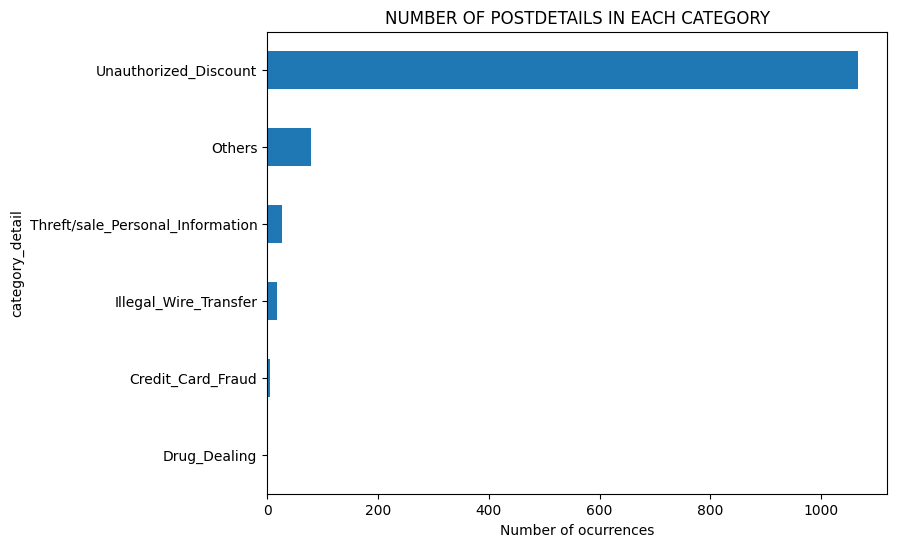

In [ ]:
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

fig = plt.figure(figsize=(8,6))
df.groupby('category_detail').category_detail.count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF POSTDETAILS IN EACH CATEGORY')
plt.xlabel('Number of ocurrences', fontsize = 10);

#2.Text processing

The text needs to be preprocessed so that we can feed it to the classification algorithm. Here we will transform the texts into vectors using Term Frequency-Inverse Document Frequency (TFIDF) and evaluate how important a particular word is in the collection of words. For this we need to remove punctuations and do lower casing, then the word importance is determined in terms of frequency.

We will be using TfidfVectorizer function with the below parameters:

1.  min_df: remove the words which has occurred in less than ‘min_df’ number of files.
2. Sublinear_tf: if True, then scale the frequency in logarithmic scale.
3.  Stop_words: it removes stop words which are predefined in ‘english’.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import re

import re
#delete other
def preprocess_text(text):
    # just keep letter and numbers
    processed_text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    return processed_text


In [ ]:
new_df = pd.DataFrame()
new_df['clean_postdetail'] = df['postDetail'].apply(preprocess_text)
new_df['category'] = df['category']
new_df['category_detail'] = df['category_detail']
new_df.head()



,clean_postdetail,category,category_detail
0,500 00 False Active 50 Sold 250 00 False In...,1,Unauthorized_Discount
1,143 31 False Active 50 SOLD 130 19 False A...,1,Unauthorized_Discount
3,almost all vanilla are sold please check the ...,1,Unauthorized_Discount
5,smooth trade,1,Unauthorized_Discount
6,Sorry for the delay Today s stock DM Bitconi...,1,Unauthorized_Discount


In [ ]:
new_df.to_csv(r'\Users\chunlan\Research\simple_project_newest\final_message_clean2.csv')

In [ ]:
pd.DataFrame(new_df.category.unique()).values

array([[1],
       [4],
       [6],
       [5],
       [2],
       [3]])

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')

# We transform each poster into a vector

features = tfidf.fit_transform(new_df.clean_postdetail).toarray()
labels = df.category
print("Each of the %d postdetails is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 1196 postdetails is represented by 1489 features (TF-IDF score of unigrams and bigrams)


Now, we will find the most correlated terms with each of the defined product categories. Here we are finding only three most correlated terms.

In [ ]:
category_id_df =new_df[['clean_postdetail', 'category']]
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'clean_postdetail']].values)

In [ ]:
df.to_csv(r'\Users\chunlan\Research\simple_project_newest\final_message_clean.csv')

In [ ]:
count=0
for key, value in category_to_id.items():
    print(key, value)
    count += 1
    if count == 10:
        break

 500 00 False Active 50   Sold 250 00 False Inital 50     Sold  143 31 False Active 50    Sold  143 31 False Active 50    Sold 130 19 False Active 50    Sold 109 47 False Active 50    Sold 102 94 False Active 50    Sold 1
 143 31 False Active 50    SOLD 130 19 False Active 50   SOLD 109 47 False Active 50   SOLD 102 94 False Active 50   SOLD 91 62 False Active 50   SOLD 89 20 False Active 50   SOLD 84 49 False Active 50  SOLD 78 98 False Active 50  SOLD 73 90 False Active 50  SOLD 73 76 False Active 50  SOLD  72 31 False Active 50  SOLD  64 59 False Active 50   SOLD 61 27 False Active 50   SOLD 59 03 False Active 50   SOLD 57 11 False Active 50   SOLD 56 23 False Active 50   SOLD 41 09 False Active 50   SOLD 38 92 False Active 50   SOLD BitconisandGC     BTC ONLY     1
 almost all vanilla are sold please check the update         1
 smooth trade         1
Sorry for the delay Today s stock  DM  BitconisandGC to buy500 00  False  Sold429 33  False  Sold100 00  False  Sold100 00  False  So

 Finding the five most correlated terms with each of the product categories


In [ ]:
"""
# Finding the three most correlated terms with each of the product categories
N = 3
for category_detail, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("n==> %s:" %(category))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))
  """

'\n# Finding the three most correlated terms with each of the product categories\nN = 3\nfor category_detail, category_id in sorted(category_to_id.items()):\n  features_chi2 = chi2(features, labels == category_id)\n  indices = np.argsort(features_chi2[0])\n  feature_names = np.array(tfidf.get_feature_names_out())[indices]\n  unigrams = [v for v in feature_names if len(v.split(\' \')) == 1]\n  bigrams = [v for v in feature_names if len(v.split(\' \')) == 2]\n  print("n==> %s:" %(category))\n  print("  * Most Correlated Unigrams are: %s" %(\', \'.join(unigrams[-N:])))\n  print("  * Most Correlated Bigrams are: %s" %(\', \'.join(bigrams[-N:])))\n  '

#3.Exploring Multi-classification Models